# Complexity simulations - Improving decision making in academia

In [1]:
# Here I will do all the imports of libraries that are useful for the work itself.

import random
import scipy.stats as stats
import statsmodels.stats.power as smp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
def ttest_simulation(numerosity2, mean1, mean2, sd1, sd2, n1, n2):
    results = []
    for _ in range(numerosity2):
        sample1 = [random.gauss(mean1, sd1) for _ in range(n1)]
        sample2 = [random.gauss(mean2, sd2) for _ in range(n2)]
        effect_size, pvalue = stats.ttest_ind(b=sample1, a=sample2, equal_var=True)
        results.append(pvalue)

    return results

## Power calculations from Jerzey 1936

These power calculations are directed from the Neyman-Pearson framework of hypothesis testing. Assuming a set of alternative hypothesis to compare to the null.

In [3]:
# This is the power calculation from the statsmodels api for the calculation of the sample size from the theoretical power and alpha level, needed to detect a .5 effect size

power_10 = smp.tt_ind_solve_power(effect_size=0.5, nobs1=10, alpha=0.001, power=None, ratio=1.0, alternative='two-sided')
power_30 = smp.tt_ind_solve_power(effect_size=0.5, nobs1=30, alpha=0.001, power=None, ratio=1.0, alternative='two-sided')
power_60 = smp.tt_ind_solve_power(effect_size=0.5, nobs1=60, alpha=0.001, power=None, ratio=1.0, alternative='two-sided')
power_100 = smp.tt_ind_solve_power(effect_size=0.5, nobs1=100, alpha=0.001, power=None, ratio=1.0, alternative='two-sided')

print("The theoretical power reached with n = 10 is", power_10, "with n=30:", power_30, "with n=60:", power_60, "with n=100:", power_100)

The theoretical power reached with n = 10 is 0.009987807856488031 with n=30: 0.07453001104470447 with n=60: 0.2694602844400545 with n=100: 0.5779677511332435


## Creation of the agent 
The agent class is going to entail a simulator function along with different strategic functions of decision making based on accepting or rejecting the Null.

In [4]:
#The actual agent Class, not sure if I want it to be visibile in the notebook or to be stored in a .py file.

class agent:
    def __init__(self,iterations,mean1,mean2,sd1,sd2,sample_size1,sample_size2,threshold):
        self.iterations = iterations
        self.mean1 = mean1
        self.mean2 = mean2
        self.sd1 = sd1
        self.sd2 = sd2
        self.sample_size1 = sample_size1
        self.sample_size2 = sample_size2
        self.threshold = threshold
        self.output = []

    def current_strategy(self):        
        pvalues = ttest_simulation(self.iterations, self.mean1, self.mean2, self.sd1, self.sd2, self.sample_size1, self.sample_size2)
        for p in pvalues:
            if p <= self.threshold:
                self.output.append(1)
            else:
                self.output.append(0)
    
    def best_of_three(self):
        if self.iterations % 3 != 0:
            raise ValueError("Invalid value for iterations. Only multiples of 3 are allowed.")
        
        pvalues = ttest_simulation(self.iterations, self.mean1, self.mean2, self.sd1, self.sd2, self.sample_size1, self.sample_size2)
    
        for i in range(0, len(pvalues), 3):
            chunk = pvalues[i:i+3]
        
            if chunk[0] <= self.threshold and chunk[1] <= self.threshold:
                self.output.append(1)
            elif chunk[0] > self.threshold and chunk[1] > self.threshold:
                self.output.append(0)
            elif chunk[0] > self.threshold and chunk[1] <= self.threshold:
                if chunk[2] <= self.threshold:
                    self.output.append(2)
                else:
                    self.output.append(3)
            elif chunk[0] <= self.threshold and chunk[1] > self.threshold:
                if chunk[2] <= self.threshold:
                    self.output.append(2)
                else:
                    self.output.append(3)

## 1. First strategy: agent1

The first strategy is the common practice in research. If I get a value below .05 I'm confident I've found something. If I get something above it, I'm confident the two samples are drawn from different populations.

### False Null - Two different populations

In [5]:
sample_size = [10,30,60,100]
false_null_dict = {}
true_null_dict = {}

for i in sample_size:
    agent1 = agent(1000,0,0.5,1,1,i,i,0.5)
    agent1.current_strategy()

    false_null_dict[f"false_null{i}"] = agent1.output.count(1)
    true_null_dict[f"true_null{i}"] = agent1.output.count(0)

In [6]:
for size in sample_size:
    print("The null hypothesis has been rejected",
        false_null_dict[f'false_null{size}'], "and has been accepted",
        true_null_dict[f'true_null{size}'], "times.")

The null hypothesis has been rejected 709 and has been accepted 291 times.
The null hypothesis has been rejected 887 and has been accepted 113 times.
The null hypothesis has been rejected 978 and has been accepted 22 times.
The null hypothesis has been rejected 1000 and has been accepted 0 times.


In [7]:
a1_data = []

for i in sample_size:
    a1_data.append({
        'Sample Size': i,
        'Null Rejected': false_null_dict[f'false_null{i}'],
        'Null Accepted': true_null_dict[f'true_null{i}']
    })

a1_df = pd.DataFrame(a1_data).set_index('Sample Size')

a1_df['Sensitivity'] = (a1_df['Null Rejected']/1000)*100
a1_df

,Null Rejected,Null Accepted,Sensitivity
Sample Size,,,
10,709,291,70.9
30,887,113,88.7
60,978,22,97.8
100,1000,0,100.0


### True Null - Populations are the same

In [8]:
sample_size = [10,30,60,100]
efalse_null_dict = {}
etrue_null_dict = {}

for i in sample_size:
    agent1e = agent(1000,0,0,1,1,i,i,0.05)
    agent1e.current_strategy()

    efalse_null_dict[f"false_null{i}"] = agent1e.output.count(1)
    etrue_null_dict[f"true_null{i}"] = agent1e.output.count(0)

In [9]:
a1_edata = []

for i in sample_size:
    a1_edata.append({
        'Sample Size': i,
        'Null Rejected': efalse_null_dict[f'false_null{i}'],
        'Null Accepted': etrue_null_dict[f'true_null{i}']
    })

a1e_df = pd.DataFrame(a1_edata).set_index('Sample Size')

a1e_df['Specificity'] = (a1e_df['Null Accepted']/1000)*100
a1e_df

,Null Rejected,Null Accepted,Specificity
Sample Size,,,
10,52,948,94.8
30,56,944,94.4
60,51,949,94.9
100,38,962,96.2


## 2. Second strategy: agent2

The second strategy is the simplest best of 3 trial. The simulation will be run for different levels of significance and in both true and false null conditions. 
- The agent is going to perform a confirmation of his study, repeating it. Always based on the significance threshold of .05. If the repetition confirms the first result, the Null is going to be either accepted or refused. 
- Eventually, if the two results are not agreeing, a third trial is going to be run WITHOUT any parameter change.

### Null is false, different populations

In [10]:
# Agent2 
sample_size = [10,30,60,100]
sum_false_null = {}
sum_true_null = {}
sum_resolve_true_null = {}
sum_resolve_false_null = {}

for i in sample_size:
    agent2 = agent(3000,0,0.5,1,1,i,i,0.5)
    agent2.best_of_three()

    sum_false_null[f"sum_false{i}"] = agent2.output.count(1)
    sum_true_null[f"sum_true{i}"] = agent2.output.count(0)
    sum_resolve_true_null[f"sum_resolve_true{i}"] = agent2.output.count(3)
    sum_resolve_false_null[f"sum_resolve_false{i}"] = agent2.output.count(2)


In [11]:
for i in sample_size:
    print("The null hypothesis has been rejected", 
        sum_false_null[f"sum_false{i}"], "and has been accepted", 
        sum_true_null[f"sum_true{i}"], "right away. It was accepted after repetition", 
        sum_resolve_true_null[f"sum_resolve_true{i}"], " times, and rejected after repetition", 
        sum_resolve_false_null[f"sum_resolve_false{i}"], "times")

The null hypothesis has been rejected 528 and has been accepted 80 right away. It was accepted after repetition 121  times, and rejected after repetition 271 times
The null hypothesis has been rejected 807 and has been accepted 8 right away. It was accepted after repetition 23  times, and rejected after repetition 162 times
The null hypothesis has been rejected 960 and has been accepted 1 right away. It was accepted after repetition 0  times, and rejected after repetition 39 times
The null hypothesis has been rejected 994 and has been accepted 0 right away. It was accepted after repetition 0  times, and rejected after repetition 6 times


In [12]:
#Creating a dataframe for the results of the agent2 simulation
a2_data = []

for i in sample_size:
    a2_data.append({
        'Sample Size': i,
        'Null Rejected':  sum_false_null[f"sum_false{i}"],
        'Null Accepted': sum_true_null[f"sum_true{i}"],
        'Null resolved true':  sum_resolve_true_null[f"sum_resolve_true{i}"],
        'Null resolved false':  sum_resolve_false_null[f"sum_resolve_false{i}"]
    })

a2_df = pd.DataFrame(a2_data).set_index('Sample Size')

a2_df['Sensitivity'] = ((a2_df['Null Rejected'] + a2_df['Null resolved false']) / 1000)*100
a2_df


,Null Rejected,Null Accepted,Null resolved true,Null resolved false,Sensitivity
Sample Size,,,,,
10,528,80,121,271,79.9
30,807,8,23,162,96.9
60,960,1,0,39,99.9
100,994,0,0,6,100.0


### Null is true, same populations

In [13]:
# Agent2 
sample_size = [10,30,60,100]
esum_false_null = {}
esum_true_null = {}
esum_resolve_true_null = {}
esum_resolve_false_null = {}

for i in sample_size:
    agent2e = agent(3000,0,0,1,1,i,i,0.05)
    agent2e.best_of_three()

    esum_false_null[f"sum_false{i}"] = agent2e.output.count(1)
    esum_true_null[f"sum_true{i}"] = agent2e.output.count(0)
    esum_resolve_true_null[f"sum_resolve_true{i}"] = agent2e.output.count(3)
    esum_resolve_false_null[f"sum_resolve_false{i}"] = agent2e.output.count(2)

In [14]:
#Creating a dataframe for the results of the agent2 simulation
a2_edata = []

for i in sample_size:
    a2_edata.append({
        'Sample Size': i,
        'Null Rejected':  esum_false_null[f"sum_false{i}"],
        'Null Accepted': esum_true_null[f"sum_true{i}"],
        'Null resolved true':  esum_resolve_true_null[f"sum_resolve_true{i}"],
        'Null resolved false':  esum_resolve_false_null[f"sum_resolve_false{i}"]
    })

a2e_df = pd.DataFrame(a2_edata).set_index('Sample Size')

a2e_df['Specificity'] = ((a2e_df['Null Accepted'] + a2e_df['Null resolved true']) / 1000)*100
a2e_df


,Null Rejected,Null Accepted,Null resolved true,Null resolved false,Specificity
Sample Size,,,,,
10,1,913,83,3,99.6
30,2,910,83,5,99.3
60,2,891,104,3,99.5
100,1,893,96,10,98.9


## 2.1 Calculating precision and accuracy only with agent1 and agent2 
At different thresholds, precision only results.

### Agent 1

In [15]:
sample_size = [10,30,60,100]
thresholds = [0.5,0.05,0.01,0.001]
agent1_sens = {}

for i in sample_size:
    for j in thresholds:
        agent1 = agent(1000,0,0.5,1,1,i,i,j)
        agent1.current_strategy()

        agent1_sens[f"Sensitivity {i}, {j}"] = (agent1.output.count(1)/1000)*100

agent1_sens    

{'Sensitivity 10, 0.5': 72.1,
 'Sensitivity 10, 0.05': 17.2,
 'Sensitivity 10, 0.01': 5.0,
 'Sensitivity 10, 0.001': 0.8999999999999999,
 'Sensitivity 30, 0.5': 90.3,
 'Sensitivity 30, 0.05': 48.8,
 'Sensitivity 30, 0.01': 20.8,
 'Sensitivity 30, 0.001': 6.6000000000000005,
 'Sensitivity 60, 0.5': 98.1,
 'Sensitivity 60, 0.05': 77.0,
 'Sensitivity 60, 0.01': 56.10000000000001,
 'Sensitivity 60, 0.001': 26.0,
 'Sensitivity 100, 0.5': 100.0,
 'Sensitivity 100, 0.05': 94.6,
 'Sensitivity 100, 0.01': 84.3,
 'Sensitivity 100, 0.001': 59.0}

In [16]:
sample_size = [10,30,60,100]
thresholds = [0.5,0.05,0.01,0.001]
agent1_spec = {}

for i in sample_size:
    for j in thresholds:
        agent1 = agent(1000,0,0,1,1,i,i,j)
        agent1.current_strategy()

        agent1_spec[f"Specificity {i}, {j}"] = (agent1.output.count(0)/1000)*100

agent1_spec    

{'Specificity 10, 0.5': 49.9,
 'Specificity 10, 0.05': 94.19999999999999,
 'Specificity 10, 0.01': 99.4,
 'Specificity 10, 0.001': 99.7,
 'Specificity 30, 0.5': 51.0,
 'Specificity 30, 0.05': 94.39999999999999,
 'Specificity 30, 0.01': 99.1,
 'Specificity 30, 0.001': 99.8,
 'Specificity 60, 0.5': 50.5,
 'Specificity 60, 0.05': 95.7,
 'Specificity 60, 0.01': 99.4,
 'Specificity 60, 0.001': 100.0,
 'Specificity 100, 0.5': 50.0,
 'Specificity 100, 0.05': 95.89999999999999,
 'Specificity 100, 0.01': 99.0,
 'Specificity 100, 0.001': 99.9}

### Agent 2

In [17]:
sample_size = [10,30,60,100]
thresholds = [0.5,0.05,0.01,0.001]
agent2_sens = {}

for i in sample_size:
    for j in thresholds:
        agent2e = agent(3000,0,0.5,1,1,i,i,j)
        agent2e.best_of_three()

        agent2_sens[f"Sensitivity {i}, {j}"] = (agent2e.output.count(1)+agent2e.output.count(2))/10

agent2_sens

{'Sensitivity 10, 0.5': 79.2,
 'Sensitivity 10, 0.05': 8.1,
 'Sensitivity 10, 0.01': 1.1,
 'Sensitivity 10, 0.001': 0.0,
 'Sensitivity 30, 0.5': 97.6,
 'Sensitivity 30, 0.05': 43.0,
 'Sensitivity 30, 0.01': 15.5,
 'Sensitivity 30, 0.001': 1.0,
 'Sensitivity 60, 0.5': 99.9,
 'Sensitivity 60, 0.05': 86.9,
 'Sensitivity 60, 0.01': 55.1,
 'Sensitivity 60, 0.001': 19.9,
 'Sensitivity 100, 0.5': 100.0,
 'Sensitivity 100, 0.05': 98.6,
 'Sensitivity 100, 0.01': 91.4,
 'Sensitivity 100, 0.001': 62.1}

In [18]:
sample_size = [10,30,60,100]
thresholds = [0.5,0.05,0.01,0.001]
agent2_spec = {}

for i in sample_size:
    for j in thresholds:
        agent2e = agent(3000,0,0,1,1,i,i,j)
        agent2e.best_of_three()

        agent2_spec[f"Specificity {i}, {j}"] = (agent2e.output.count(0)+agent2e.output.count(3))/10

agent2_spec

{'Specificity 10, 0.5': 47.8,
 'Specificity 10, 0.05': 99.6,
 'Specificity 10, 0.01': 100.0,
 'Specificity 10, 0.001': 100.0,
 'Specificity 30, 0.5': 50.5,
 'Specificity 30, 0.05': 99.6,
 'Specificity 30, 0.01': 100.0,
 'Specificity 30, 0.001': 100.0,
 'Specificity 60, 0.5': 50.1,
 'Specificity 60, 0.05': 99.2,
 'Specificity 60, 0.01': 100.0,
 'Specificity 60, 0.001': 100.0,
 'Specificity 100, 0.5': 50.5,
 'Specificity 100, 0.05': 99.1,
 'Specificity 100, 0.01': 100.0,
 'Specificity 100, 0.001': 100.0}

## 3 Sensitivity and specificity phenomenon

Noticed that precision is increasing with the best of 3 strategy on large samples, but it's decreasing on smaller sample sizes. Basically using p-value as a guiding tool, repetition is more dangerous at low n values.


## 3.1 False Null - Sensitivity Testing

### Agent 1 Series 

Both for true and false null, with different significance thresholds

In [19]:
thresholds = [0.5,0.05,0.01,0.001]
agent1_sens = {}

for j in thresholds:
    sensitivity_values = []
    for i in range(10, 100):
        agent1 = agent(1000, 0, 0.5, 1, 1, i, i, j)
        agent1.current_strategy()
        sensitivity = (agent1.output.count(1) / 1000) * 100
        sensitivity_values.append(sensitivity)
    agent1_sens[f"Sensitivity {j}"] = sensitivity_values

agent1_sens 

{'Sensitivity 0.5': [69.6,
  73.2,
  74.9,
  76.8,
  74.8,
  76.4,
  79.10000000000001,
  81.69999999999999,
  81.69999999999999,
  82.5,
  82.8,
  82.39999999999999,
  84.6,
  85.3,
  86.5,
  84.89999999999999,
  87.7,
  90.0,
  90.60000000000001,
  89.9,
  88.7,
  91.60000000000001,
  90.7,
  90.60000000000001,
  92.7,
  92.9,
  94.1,
  95.3,
  93.60000000000001,
  93.8,
  94.3,
  93.7,
  94.5,
  95.6,
  95.6,
  95.0,
  95.19999999999999,
  96.3,
  95.8,
  97.2,
  96.39999999999999,
  97.1,
  96.0,
  96.7,
  96.89999999999999,
  98.1,
  97.6,
  98.1,
  97.39999999999999,
  97.89999999999999,
  98.6,
  98.2,
  98.2,
  98.1,
  98.6,
  98.8,
  98.7,
  98.7,
  99.5,
  98.5,
  98.6,
  99.7,
  98.7,
  99.3,
  99.2,
  98.9,
  99.2,
  98.9,
  99.3,
  99.1,
  99.3,
  99.3,
  99.3,
  99.5,
  99.5,
  99.3,
  99.7,
  99.6,
  99.8,
  99.7,
  99.6,
  99.6,
  99.7,
  99.7,
  99.8,
  99.6,
  99.7,
  100.0,
  99.9,
  100.0],
 'Sensitivity 0.05': [20.0,
  21.4,
  19.900000000000002,
  23.4000000000000

In [20]:
# Create a list for y values
y_values1_05_f = agent1_sens[f"Sensitivity {0.5}"]
y_values1_005_f = agent1_sens[f"Sensitivity {0.05}"]
y_values1_001_f = agent1_sens[f"Sensitivity {0.01}"]
y_values1_0001_f = agent1_sens[f"Sensitivity {0.001}"]


### Agent 2 Series

Alos in this case we check for Sensitivity series. We don't check for specificity due to it not being involved in NHST.

In [21]:
thresholds = [0.5,0.05,0.01,0.001]
agent2_sens = {}

for j in thresholds :
    sensitivity_values = []
    for i in range(10,100):
        agent2e = agent(3000,0,0.5,1,1,i,i,j)
        agent2e.best_of_three()
        sensitivity = (agent2e.output.count(1) / 1000) * 100
        sensitivity_values.append(sensitivity)
    agent2_sens[f"Sensitivity {j}"] = sensitivity_values



In [22]:
# Create a list for y values
y_values2_05_f = agent2_sens[f"Sensitivity {0.5}"]
y_values2_005_f = agent2_sens[f"Sensitivity {0.05}"]
y_values2_001_f = agent2_sens[f"Sensitivity {0.01}"]
y_values2_0001_f = agent2_sens[f"Sensitivity {0.001}"]



<AxesSubplot: >

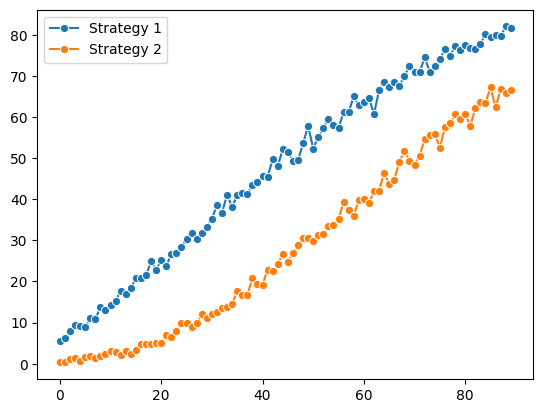

In [23]:
# Create a numeric index for the y-values
x_values_1 = range(len(y_values1_001_f))
x_values_2 = range(len(y_values2_001_f))

# Plot the y-values as a line plot
sns.lineplot(x=x_values_1, y=y_values1_001_f, marker='o', label='Strategy 1')

# Plot another set of y-values on top of the first plot
sns.lineplot(x=x_values_2, y=y_values2_001_f, marker='o', label='Strategy 2')

### Gaphic representation for Sensitivity: false Null


<AxesSubplot: >

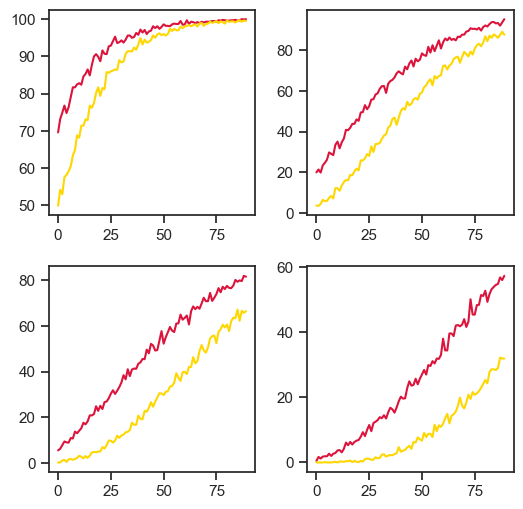

In [24]:
sensitivity_g = plt.figure(figsize=[6,6]) #Generically defines the size of the figure that will be populated by subplots by sns
sensitivity_g.subplots_adjust(hspace=.25, wspace=.25)

# First subplot - Sensitivity - 0.5 significance
sns.set_theme(style="ticks")
ax1 = sensitivity_g.add_subplot(2,2,1)
sns.lineplot(x=x_values_1, y=y_values1_05_f, color="Crimson")
sns.lineplot(x=x_values_1, y=y_values2_05_f, color="Gold")

# Second subplot - Sensitivity - 0.05 significance
sns.set_theme(style="ticks")
ax1 = sensitivity_g.add_subplot(2,2,2)
sns.lineplot(x=x_values_1, y=y_values1_005_f, color="Crimson")
sns.lineplot(x=x_values_1, y=y_values2_005_f, color="Gold")

# Third subplot - Sensitivity - 0.01 significance
sns.set_theme(style="ticks")
ax1 = sensitivity_g.add_subplot(2,2,3)
sns.lineplot(x=x_values_1, y=y_values1_001_f, color="Crimson")
sns.lineplot(x=x_values_1, y=y_values2_001_f, color="Gold")

# Third subplot - Sensitivity - 0.001 significance
sns.set_theme(style="ticks")
ax1 = sensitivity_g.add_subplot(2,2,4)
sns.lineplot(x=x_values_1, y=y_values1_0001_f, color="Crimson")
sns.lineplot(x=x_values_1, y=y_values2_0001_f, color="Gold")

## 3.2 True  Null - Specificity Testing


### Agent 1 Series

In [25]:
thresholds = [0.5,0.05,0.01,0.001]
agent1_spec = {}

for j in thresholds:
    specificity_values = []
    for i in range(10, 100):
        agent1 = agent(1000, 0, 0.5, 1, 1, i, i, j)
        agent1.current_strategy()
        specificity = (agent1.output.count(1) / 1000) * 100
        specificity_values.append(specificity)
    agent1_sens[f"Specificity {j}"] = specificity_values

agent1_spec 

{}

In [26]:
# Create a list for y values
y_values1_05_t = agent1_sens[f"Specificity {0.5}"]
y_values1_005_t = agent1_sens[f"Specificity {0.05}"]
y_values1_001_t = agent1_sens[f"Specificity {0.01}"]
y_values1_0001_t = agent1_sens[f"Specificity {0.001}"]


### Agent 2 Series - True Null

In [27]:
thresholds = [0.5,0.05,0.01,0.001]
agent2_spec = {}

for j in thresholds :
    specificity_values = []
    for i in range(10,100):
        agent2e = agent(3000,0,0.5,1,1,i,i,j)
        agent2e.best_of_three()
        specificity = (agent2e.output.count(1) / 1000) * 100
        specificity_values.append(specificity)
    agent2_spec[f"Specificity {j}"] = specificity_values



In [28]:
# Create a list for y values
y_values2_05_t = agent2_spec[f"Specificity {0.5}"]
y_values2_005_t = agent2_spec[f"Specificity {0.05}"]
y_values2_001_t = agent2_spec[f"Specificity {0.01}"]
y_values2_0001_t = agent2_spec[f"Specificity {0.001}"]


<AxesSubplot: >

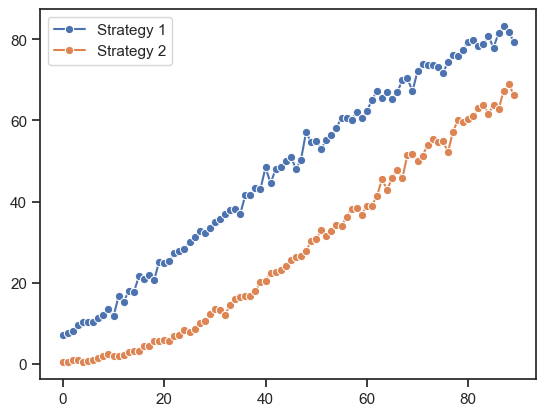

In [29]:
# Create a numeric index for the y-values
x_values_1 = range(len(y_values1_001_t))
x_values_2 = range(len(y_values2_001_t))

# Plot the y-values as a line plot
sns.lineplot(x=x_values_1, y=y_values1_001_t, marker='o', label='Strategy 1')

# Plot another set of y-values on top of the first plot
sns.lineplot(x=x_values_2, y=y_values2_001_t, marker='o', label='Strategy 2')

### Graphic representation for the True Null - Specificity

<AxesSubplot: >

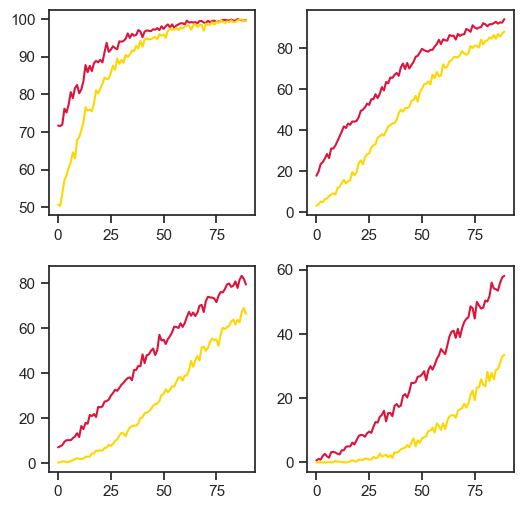

In [30]:
specificity_g = plt.figure(figsize=[6,6]) #Generically defines the size of the figure that will be populated by subplots by sns
specificity_g.subplots_adjust(hspace=.25, wspace=.25)

# First subplot - Sensitivity - 0.5 significance
sns.set_theme(style="ticks")
ax1 = specificity_g.add_subplot(2,2,1)
sns.lineplot(x=x_values_1, y=y_values1_05_t, color="Crimson")
sns.lineplot(x=x_values_1, y=y_values2_05_t, color="Gold")

# Second subplot - Sensitivity - 0.05 significance
sns.set_theme(style="ticks")
ax1 = specificity_g.add_subplot(2,2,2)
sns.lineplot(x=x_values_1, y=y_values1_005_t, color="Crimson")
sns.lineplot(x=x_values_1, y=y_values2_005_t, color="Gold")

# Third subplot - Sensitivity - 0.01 significance
sns.set_theme(style="ticks")
ax1 = specificity_g.add_subplot(2,2,3)
sns.lineplot(x=x_values_1, y=y_values1_001_t, color="Crimson")
sns.lineplot(x=x_values_1, y=y_values2_001_t, color="Gold")

# Third subplot - Sensitivity - 0.001 significance
sns.set_theme(style="ticks")
ax1 = specificity_g.add_subplot(2,2,4)
sns.lineplot(x=x_values_1, y=y_values1_0001_t, color="Crimson")
sns.lineplot(x=x_values_1, y=y_values2_0001_t, color="Gold")